### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150

### Helper Functions

In [3]:
def df_object_to_num(df_obj):
    
    """
    Custom function to transform categorical features into numerical ones.
    This function will also be applied on the testing data so that we apply the same exact kind of transformation
    """
    
    #make deep copy
    df_num = df_obj.copy()
    
    #keep track of columns to drop at end
    col_drop_list = ['emp_title']
    
    df_num['mort_acc'] = np.where(df_num['mort_acc'].isnull(), 0,df_num['mort_acc'])
    
    #pub_rec_bankruptcies
    df_num['pub_rec_bankruptcies'] = np.where(df_num['pub_rec_bankruptcies']>0, 1, 0)
    
    # pub_rec
    df_num['pub_rec'] = np.where(df_num['pub_rec']>0, 1, 0)
    
     ### instantiate dicts ### 
    term_to_int = {' 36 months': 1, ' 60 months': 2}
    grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))
    
    #copied from above, we can write a function to generate this dict
    sub_grade_sorted = {
        'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34
    }   
    home_to_int = {'MORTGAGE': 4, 'RENT': 3, 'OWN': 5,'ANY': 2,'OTHER': 1, 'NONE':0 }
    ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0} 
    
    #replacements
    df_num.replace({'term': term_to_int, 'grade':grade_to_int,'sub_grade': sub_grade_sorted, 'home_ownership':home_to_int,'verification_status':ver_stat_to_int}, inplace=True)
    
    #fix zip codes and keep first 3
    df_num['zip_3'] = df_num['zip_code'].str.replace('x','')
    df_num['zip_2'] = df_num['zip_3'].str[:2]
    col_drop_list.append('zip_code')
    
    #drop nans in case we missed any
    df_num = df_num.dropna(axis=0)
    
    df_num['earliest_cr_line']=  pd.to_datetime(df_num['earliest_cr_line'], infer_datetime_format=True)
    df_num['issue_d']=  pd.to_datetime(df_num['issue_d'], infer_datetime_format=True)
    credit_hist= df_num['issue_d'] - df_num['earliest_cr_line']
    df_num['credit_hist']=credit_hist.dt.days
    
    col_drop_list.append('earliest_cr_line')
    col_drop_list.append('issue_d')

    # credit_line_ratio 
    df_num['credit_line_ratio']=df_num['open_acc']/df_num['total_acc']
    col_drop_list.extend(['open_acc','total_acc'])
    
    #Balance_annual_income
    df_num['balance_annual_inc'] = df_num['loan_amnt'] / df_num['annual_inc']
    
    df_num['annual_inc']+=1
    df_num['annual_inc']=np.log(df_num['annual_inc'])
    
    df_num['fico_avg_score'] = (df_num['fico_range_high']+df_num['fico_range_low'] )/2
    col_drop_list.extend(['fico_range_high','fico_range_low'])

    df_num['inst_amnt_ratio']=df_num['installment']/df_num['loan_amnt']
    col_drop_list.extend(['installment','loan_amnt'])
    
    #fix zip codes and keep first 3
    df_num['zip_3'] = df_num['zip_code'].str.replace('x','')
    df_num['zip_2'] = df_num['zip_3'].str[:2]
    col_drop_list.append('zip_code')
    
    df_num  = df_num.drop(columns=col_drop_list)
    
    return df_num


In [4]:
def custom_scaler(df_unscaled, zip_means, zip_std):
    """
    Applies a custom scaling to a dataframe based on observations in same 2 digit zip code
    returns new dataframe
    
    """
    
    #nested for loops to scale by 2 digit zip code
    df_scaled_list = []
    for code in df_unscaled['zip_2'].unique():
        #make deep copy of localized zip
        df_local_zip = df_unscaled[df_unscaled['zip_2']==code].copy()

        #for each feature we want to scale
        for feat in zip_means.columns:
            #subtract and divide by std
            df_local_zip[feat] = (df_local_zip[feat] - zip_means.loc[code,feat]) / zip_std.loc[code,feat]
        
        #after scaling is done for local zip area we append to list
        df_scaled_list.append(df_local_zip)


    #concat in one df
    df_scaled = pd.concat(df_scaled_list)
    
    return df_scaled

### Read in training and testing datasets

In [5]:
#get directory
df_train_path = os.path.join('..', 'data', 'training_data', 'df_train.csv.zip')
df_test_path = os.path.join('..', 'data', 'training_data', 'df_test.csv.zip')

df = pd.read_csv(df_train_path, low_memory=False)
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10.0,MORTGAGE,55000.0,Not Verified,2015-12-01,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,2,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,...,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10.0,MORTGAGE,65000.0,Not Verified,2015-12-01,0,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,11,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,...,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [6]:
df.shape

(1143145, 152)

In [7]:
cols = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
             'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
             'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 
             'initial_list_status', 'mo_sin_old_rev_tl_op', 'mo_sin_old_il_acct','last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
             'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
             'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 
             'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  
             'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq',     'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 
             'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'last_fico_range_high','last_fico_range_low','url','id','title','addr_state',
             'tot_hi_cred_lim','total_bal_ex_mort', 'total_bc_limit', 
             'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 
             'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
             'total_rev_hi_lim','Unnamed: 0']

#drop leaks
df_small = df.drop(columns=cols, axis=1)
drop_col_count = len(cols)
print("The new dataframe has {} columns and lost {} after dropping cols".format(df_small.shape[1], drop_col_count))

The new dataframe has 86 columns and lost 66 after dropping cols


In [8]:
df_small.shape

(1143145, 86)

In [9]:
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = df_small.apply(pd.Series.nunique)

#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)

['policy_code', 'application_type', 'hardship_type', 'deferral_term', 'hardship_length']


In [10]:
# drop the redundant columns
df_small = df_small.drop(columns=single_value_cols)

In [11]:
#make dataframe to record mean missing
nan_df = pd.DataFrame(df_small.isna().mean(), columns=['mean_nan'])

#add dtypes
nan_df['dtypes'] = df_small.dtypes

#sort by most missing at top
nan_df = nan_df.sort_values(by=['mean_nan'], ascending=False)
nan_df = nan_df.reset_index()
nan_df.head()

,index,mean_nan,dtypes
0,member_id,1.0,float64
1,revol_bal_joint,1.0,float64
2,verification_status_joint,1.0,float64
3,dti_joint,1.0,float64
4,annual_inc_joint,1.0,float64


In [12]:
# Dropping Columns based on missing data being more than 90% 
a=df_small.isnull().sum()/len(df_small)*100
variables = df_small.columns
variable = [ ]
for i in range(0,len(df_small.columns)):
    if a[i]<50:   #setting the threshold as 90% (MissingValue)
        variable.append(variables[i])

# Dropping Columns based on missing data being more than 60% 
drop_columns1=list(set(variables) - set(variable))
df_drop_nan=df_small.drop(columns=drop_columns1)

In [13]:
df_drop_nan.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,dti,earliest_cr_line,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,3600.0,36 months,13.99,123.03,C,C4,leadman,10.0,MORTGAGE,55000.0,Not Verified,2015-12-01,0,2,190xx,5.91,Aug-2003,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0
1,24700.0,36 months,11.99,820.28,C,C1,Engineer,10.0,MORTGAGE,65000.0,Not Verified,2015-12-01,0,11,577xx,16.06,Dec-1999,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0
2,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3.0,MORTGAGE,104433.0,Source Verified,2015-12-01,0,6,174xx,25.37,Jun-1998,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0
3,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4.0,RENT,34000.0,Source Verified,2015-12-01,0,2,300xx,10.20,Oct-1987,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0
4,20000.0,36 months,9.17,637.58,B,B2,Vice President of Recruiting Operations,10.0,MORTGAGE,180000.0,Not Verified,2015-12-01,0,2,550xx,14.67,Jun-1990,680.0,684.0,12.0,0.0,87329.0,84.5,27.0,4.0,0.0


In [14]:
a = df_drop_nan.isnull().sum() / len(df_drop_nan)*100
a.sort_values()

loan_amnt               0.000000
revol_bal               0.000000
fico_range_high         0.000000
fico_range_low          0.000000
dti                     0.000000
purpose                 0.000000
issue_d                 0.000000
verification_status     0.000000
loan_status             0.000000
installment             0.000000
emp_length              0.000000
term                    0.000000
int_rate                0.000000
sub_grade               0.000000
grade                   0.000000
home_ownership          0.000000
zip_code                0.000087
annual_inc              0.000350
open_acc                0.002537
pub_rec                 0.002537
total_acc               0.002537
earliest_cr_line        0.002537
revol_util              0.059485
pub_rec_bankruptcies    0.119407
mort_acc                4.376523
emp_title               6.072895
dtype: float64

In [15]:
#make entries numerical
df_num = df_object_to_num(df_drop_nan)
df_num.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,zip_3,zip_2,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,1,13.99,5,21,10.0,4,10.915107,0,0,2,5.91,0,2765.0,29.7,1.0,0,190,19,4505,0.538462,0.065455,677.0,0.034175
1,1,11.99,5,24,10.0,4,11.082158,0,0,11,16.06,0,21470.0,19.2,4.0,0,577,57,5844,0.578947,0.380000,717.0,0.033210
2,2,22.45,2,9,3.0,4,11.556311,2,0,6,25.37,0,21929.0,64.5,6.0,0,174,17,6392,0.342857,0.099585,697.0,0.027876
3,1,13.44,5,22,4.0,3,10.434145,2,0,2,10.20,0,8822.0,68.4,0.0,0,300,30,10288,0.833333,0.351471,692.0,0.033906
4,1,9.17,6,28,10.0,4,12.100718,0,0,2,14.67,0,87329.0,84.5,4.0,0,550,55,9314,0.444444,0.111111,682.0,0.031879


In [16]:
#instantiate groupby object
df_macro_groupby = df_num.drop(columns=['zip_3']).groupby(by='zip_2')

In [17]:
scale_cols=['term', 'int_rate', 'grade', 'sub_grade', 'emp_length','home_ownership', 'annual_inc', 'verification_status','purpose', 'dti',
            'revol_bal','revol_util', 'mort_acc','credit_hist', 'credit_line_ratio', 'balance_annual_inc','fico_avg_score','inst_amnt_ratio']

In [18]:
#get mean
df_macro_mean = df_macro_groupby.mean()

#eliminate binary features
df_macro_mean = df_macro_mean[scale_cols]
df_macro_mean.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,revol_bal,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
zip_2,,,,,,,,,,,,,,,,,,
00,1.181818,13.018182,5.272727,23.363636,7.181818,3.818182,11.088423,0.818182,2.454545,20.370909,14340.181818,51.227273,1.000000,5600.454545,0.487693,0.215835,697.000000,0.031794
01,1.269559,12.645396,5.374430,23.970713,6.095039,3.702066,11.168798,1.089521,2.495312,17.142621,18712.639260,52.937908,1.719655,5950.253962,0.504081,0.217296,700.473492,0.030637
02,1.244207,12.695069,5.368768,23.903914,5.834292,3.565239,11.151513,1.075931,2.489643,16.728669,18146.955335,53.652513,1.386131,5749.092010,0.512496,0.211037,698.983139,0.030935
03,1.242176,12.760563,5.352099,23.822710,6.221374,3.741412,11.122337,1.040267,2.502863,18.650784,17877.933015,54.487805,1.842366,5967.987405,0.488050,0.209294,699.160401,0.030986
04,1.221943,12.412429,5.386935,24.010888,6.159966,3.854271,11.000826,1.118928,2.345896,19.609414,16172.835846,54.219095,1.847571,6175.922948,0.485198,0.232221,696.849246,0.031061


In [19]:
#save statistics for later use
df_macro_mean.to_csv('../data/stats/df_macro_mean.csv')

In [20]:
#get std
df_macro_std = df_macro_groupby.std()

df_macro_std = df_macro_std[scale_cols]

df_macro_std.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,revol_bal,revol_util,mort_acc,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
zip_2,,,,,,,,,,,,,,,,,,
00,0.404520,5.032591,1.420627,6.874194,3.092513,0.603023,0.461202,0.750757,2.381749,12.408343,5844.465413,20.831567,1.264911,2486.885175,0.156975,0.106464,22.472205,0.003864
01,0.443749,4.650108,1.314324,6.556430,3.599464,0.622959,0.498040,0.842590,2.135491,7.861925,24419.824656,24.148594,2.065026,2643.734784,0.168556,0.103749,32.971923,0.004286
02,0.429628,4.619841,1.309402,6.527431,3.637513,0.638322,0.497872,0.845679,2.182871,7.930908,28212.635027,24.313658,1.957755,2633.742314,0.175479,0.104706,31.797147,0.004174
03,0.428441,4.594048,1.298051,6.451225,3.615337,0.617028,0.520333,0.840439,2.124847,7.886471,23615.496696,24.345290,2.106797,2506.459847,0.168764,0.108564,32.427826,0.004208
04,0.415727,4.668135,1.236913,6.124639,3.701504,0.652960,0.491447,0.847615,2.052567,8.122123,15945.872599,24.349542,1.949543,2644.731895,0.169490,0.115727,30.412405,0.004070


In [21]:
#save statistics for later use
df_macro_std.to_csv(os.path.join('../data/stats/df_macro_std.csv'))

In [22]:
#get counts
df_macro_count = pd.DataFrame(df_num['zip_2'].value_counts())
df_macro_count.head()

,zip_2
33,41001
92,39327
11,36680
60,32582
30,28607


Text(0.5, 1.0, 'Distribution of Loan Applications by 2 Digit Zip Code')

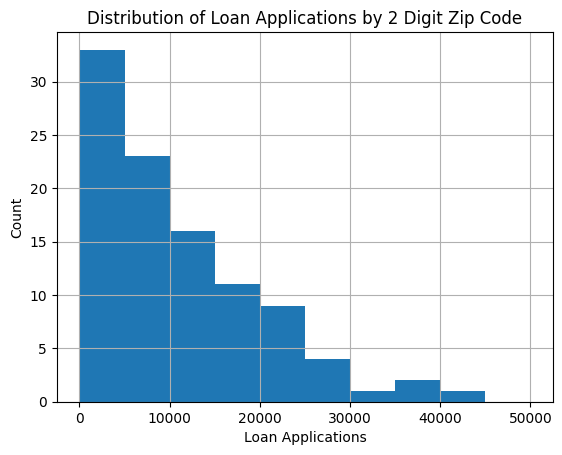

In [23]:
df_macro_count.hist(column='zip_2', bins=np.arange(0, 55_000, 5000))
plt.xlabel("Loan Applications")
plt.ylabel("Count")
plt.title("Distribution of Loan Applications by 2 Digit Zip Code")

In [24]:
df_train_scaled = custom_scaler(df_unscaled=df_num, zip_means = df_macro_mean, zip_std = df_macro_std)
df_train_scaled.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,zip_3,zip_2,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.608872,0.164693,-0.163457,-0.325463,1.122052,0.447071,-0.429185,-1.307963,0,-0.284092,-1.473992,0,-0.546784,-1.023435,-0.312566,0,190,19,-0.507738,0.163442,-1.289327,-0.664438,0.751798
67,1.642269,1.571844,-1.681827,-1.852288,-1.097898,2.003534,0.922524,-1.307963,1,-1.129831,0.315839,0,0.051569,1.656392,0.185487,0,197,19,1.811497,-0.290346,0.013519,-1.142713,-0.953725
109,-0.608872,0.164693,-0.163457,-0.325463,-1.097898,-1.109391,0.373296,1.107810,0,-0.284092,0.504437,0,-0.039984,1.171393,-0.810619,0,197,19,-0.405765,-0.661155,-1.119129,-0.505013,0.751305
166,-0.608872,0.045809,-0.163457,-0.172780,-1.375392,-1.109391,-1.966736,1.107810,0,-0.284092,1.057904,0,-0.491274,-0.982334,-0.810619,0,191,19,-1.030678,0.453866,-0.581365,0.451536,0.690353
240,-0.608872,0.350584,-0.163457,-0.478145,-1.097898,-1.109391,-0.044315,1.107810,0,-0.706962,1.628628,0,-0.101400,0.123301,-0.810619,0,191,19,0.015201,-0.203410,-1.206653,-0.823863,0.847883


### Test data read

In [26]:
#load test data
df_test = pd.read_csv(df_test_path,low_memory=False)

In [28]:
#drop leak columns
df_test = df_test.drop(columns=cols, axis=1)

# drop the redundant columns
df_test = df_test.drop(columns=single_value_cols)

#drop the columns
df_test = df_test.drop(columns=drop_columns1)

In [31]:
#make numerical
df_test_num = df_object_to_num(df_test)

#scale 
df_test_scaled = custom_scaler(df_test_num, df_macro_mean, df_macro_std)

In [32]:
df_test_scaled = df_test_scaled.drop(columns=['zip_3','zip_2'], axis=1)
df_train_scaled = df_train_scaled.drop(columns=['zip_3','zip_2'], axis=1)

In [33]:
different_columns = set.difference(set(df_train_scaled.columns), set(df_test_scaled.columns))
different_columns

set()

In [34]:
df_train_scaled.shape,df_test_scaled.shape

((1073090, 21), (194208, 21))

In [35]:
df_train_scaled.isnull().sum()

term                    0
int_rate                0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
loan_status             0
purpose                 0
dti                     0
pub_rec                 0
revol_bal               0
revol_util              0
mort_acc                0
pub_rec_bankruptcies    0
credit_hist             0
credit_line_ratio       0
balance_annual_inc      0
fico_avg_score          0
inst_amnt_ratio         0
dtype: int64

In [36]:
#save as compressed zipped files to save space
df_train_scaled.to_csv(os.path.join('..', 'data', 'training_data' ,'df_train_scaled.csv'), compression='zip')
df_test_scaled.to_csv(os.path.join('..', 'data', 'training_data' ,'df_test_scaled.csv'), compression='zip')

In [37]:
df=df_train_scaled

In [38]:
df_paid = df[df['loan_status']==0]
df_default = df[df['loan_status']==1]

In [39]:
#get continuous target variables
cont_cols = [x for x in df.columns if len(df[x].value_counts())>10]

cont_cols

['term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'dti',
 'revol_bal',
 'revol_util',
 'mort_acc',
 'credit_hist',
 'credit_line_ratio',
 'balance_annual_inc',
 'fico_avg_score',
 'inst_amnt_ratio']

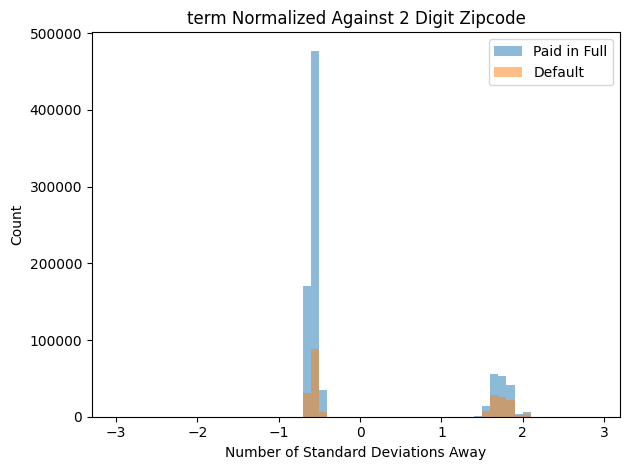

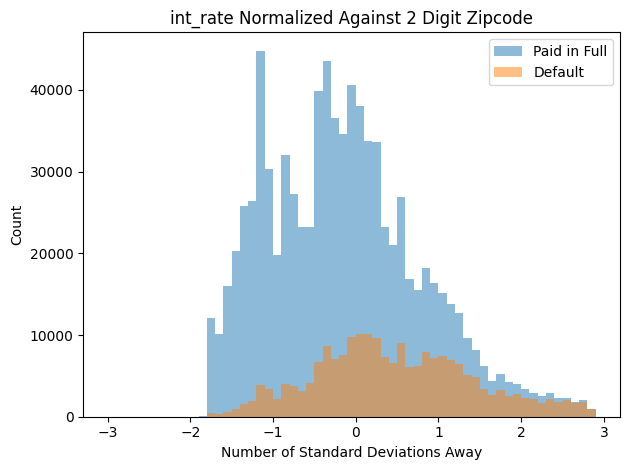

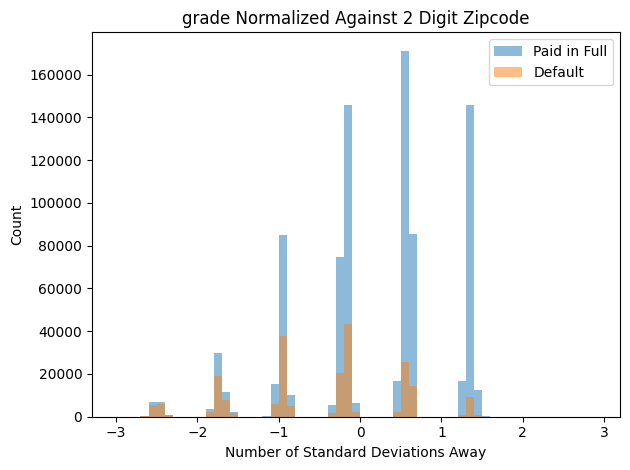

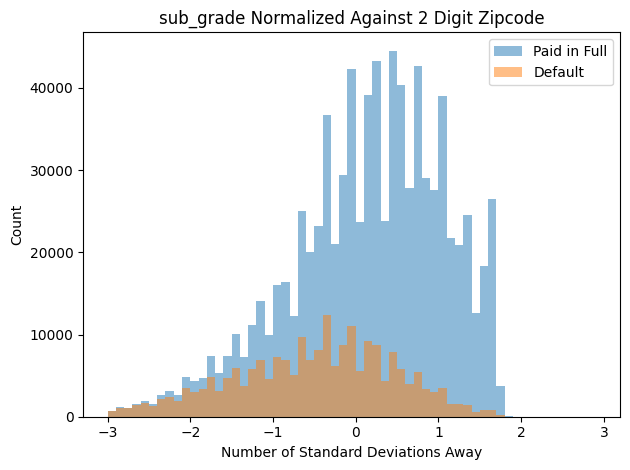

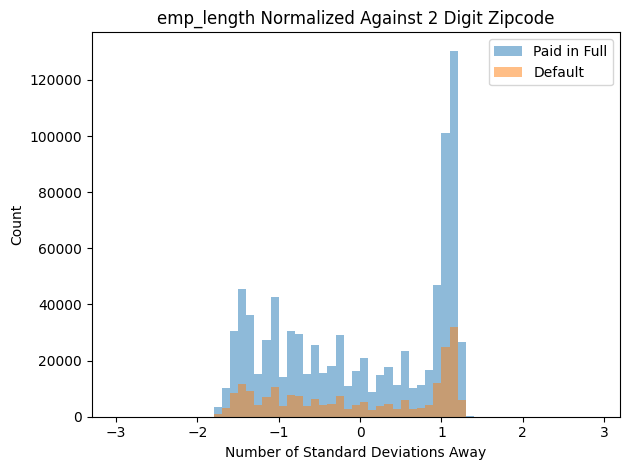

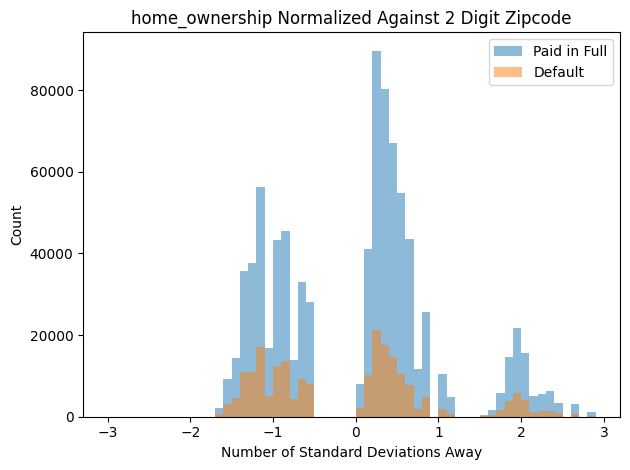

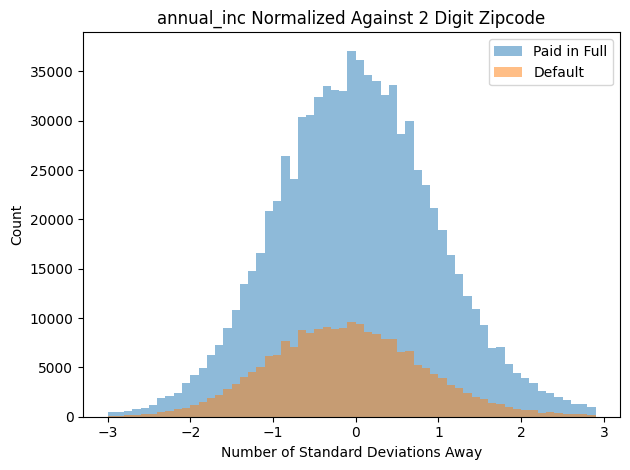

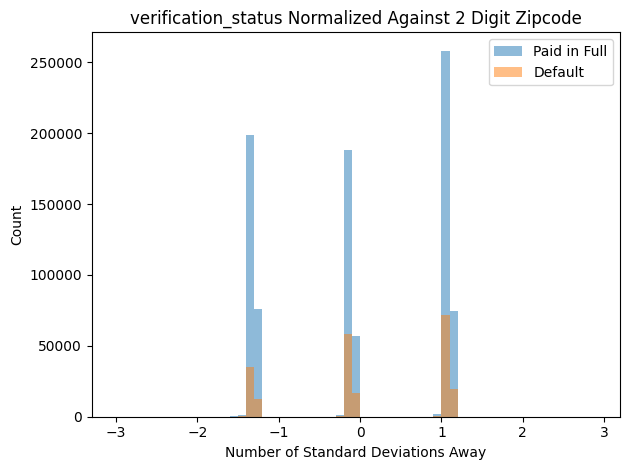

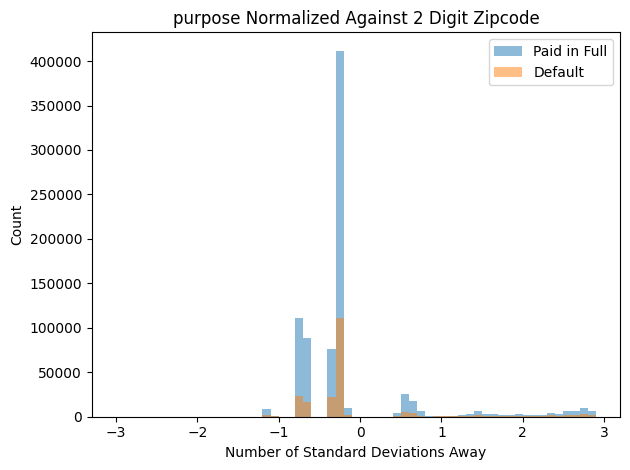

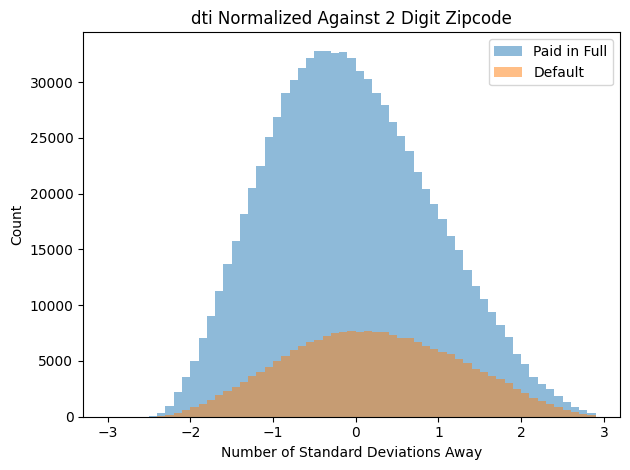

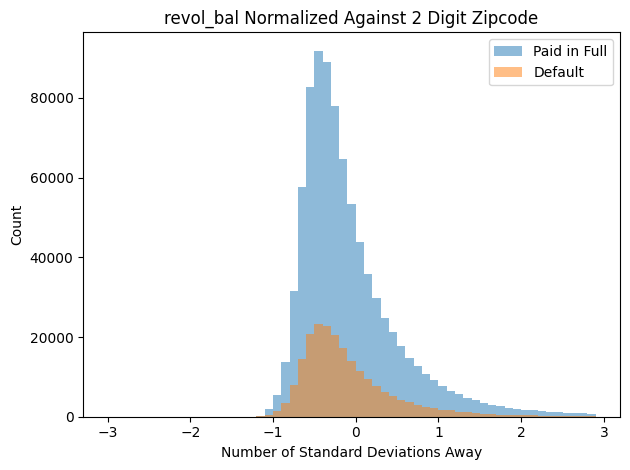

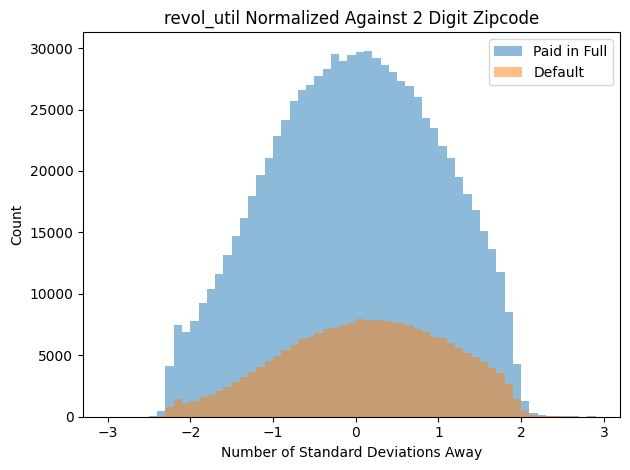

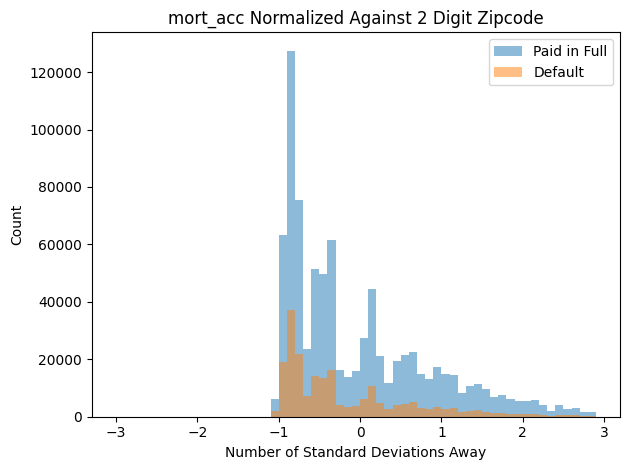

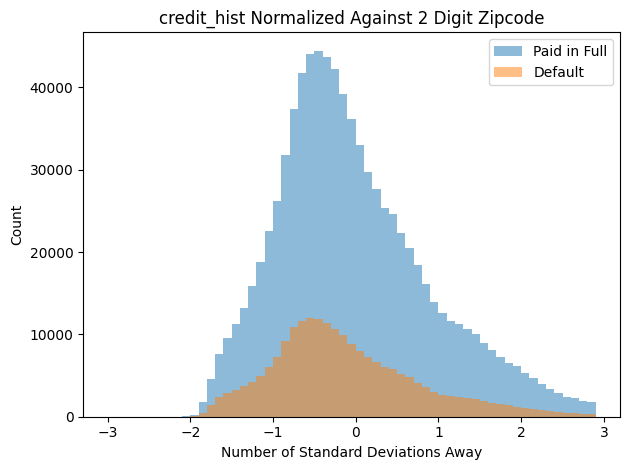

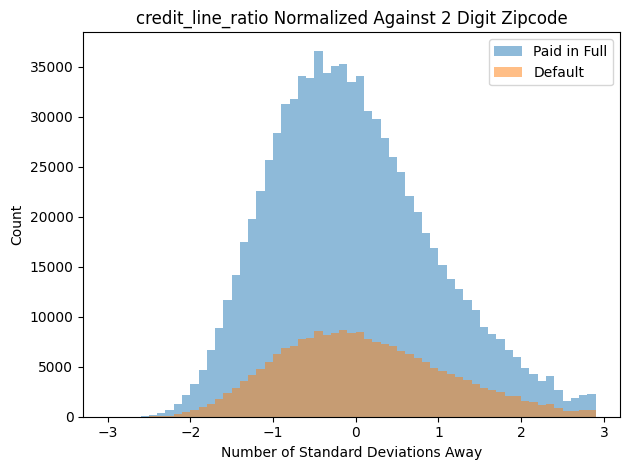

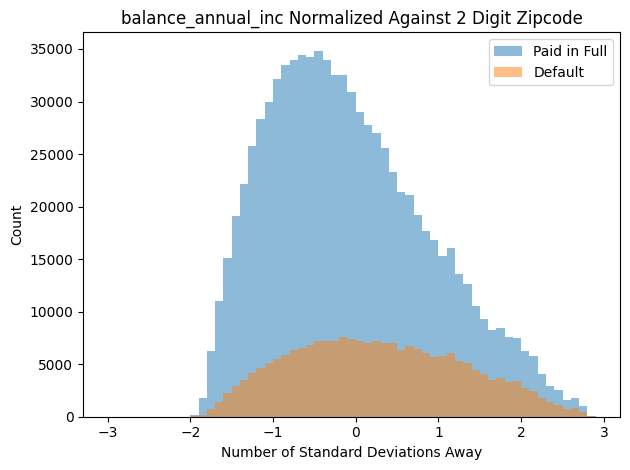

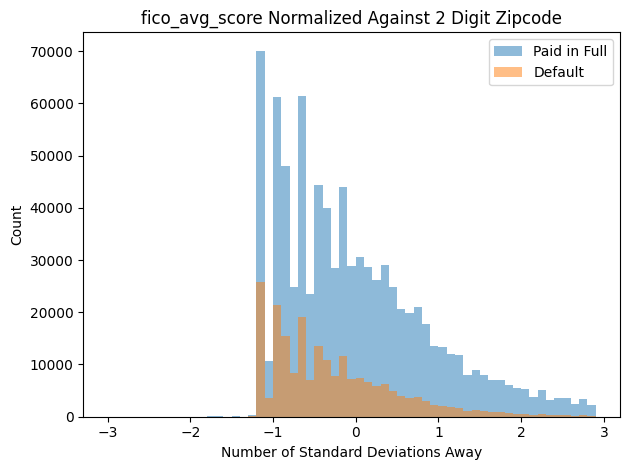

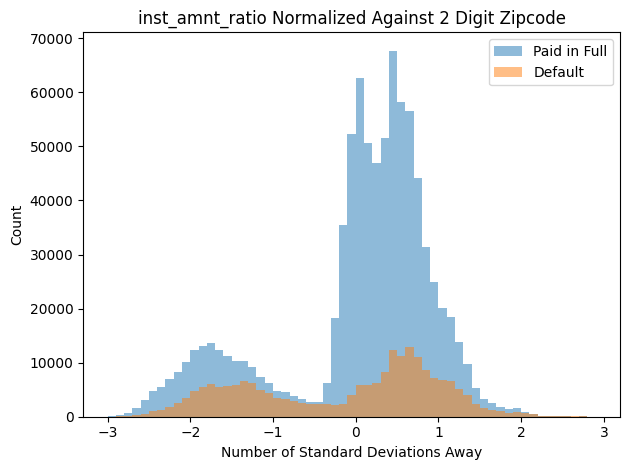

In [40]:
for c in cont_cols:
    plt.hist(df_paid[c], bins=np.arange(-3, 3, 0.1), label='Paid in Full', alpha=0.5)
    plt.hist(df_default[c], bins=np.arange(-3, 3, 0.1), label='Default', alpha=0.5)
    plt.ylabel("Count")
    plt.xlabel("Number of Standard Deviations Away")
    plt.title("{} Normalized Against 2 Digit Zipcode".format(c))
    plt.legend()
    plt.tight_layout()
    plt.show()